In [1]:
import gzip
import yaml
import rich
import uproot
import correctionlib
import numpy as np
import mplhep as hep
import correctionlib.convert
import matplotlib.pyplot as plt
from correctionlib import schemav2 as cs
with open("../analysis/postprocess/style.yaml", "r") as f:
    style = yaml.safe_load(f)
plt.rcParams.update(style["rcParams"])

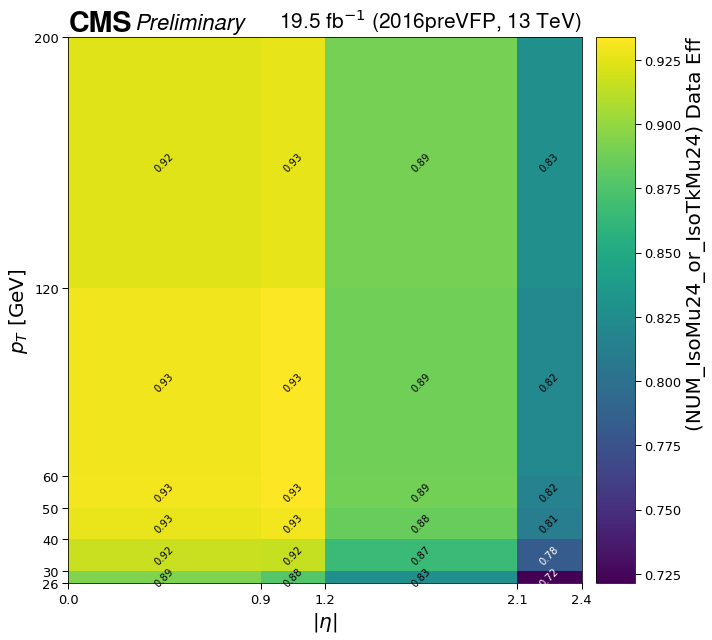

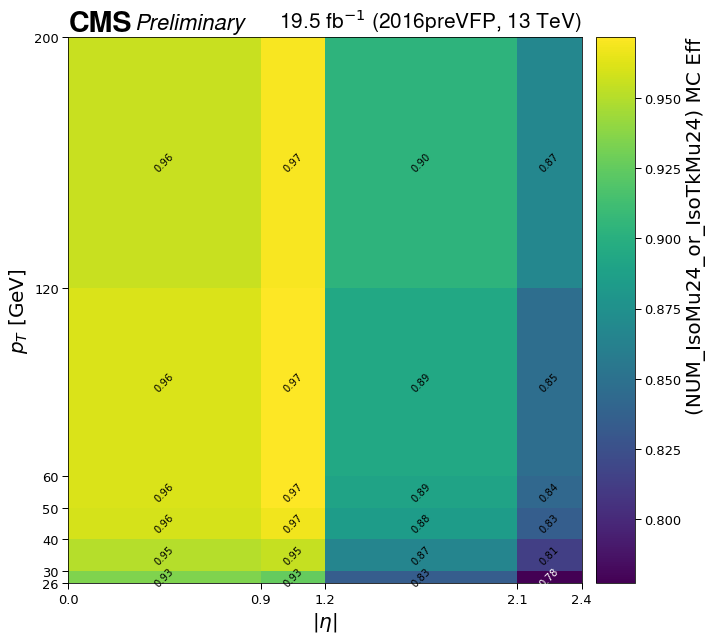

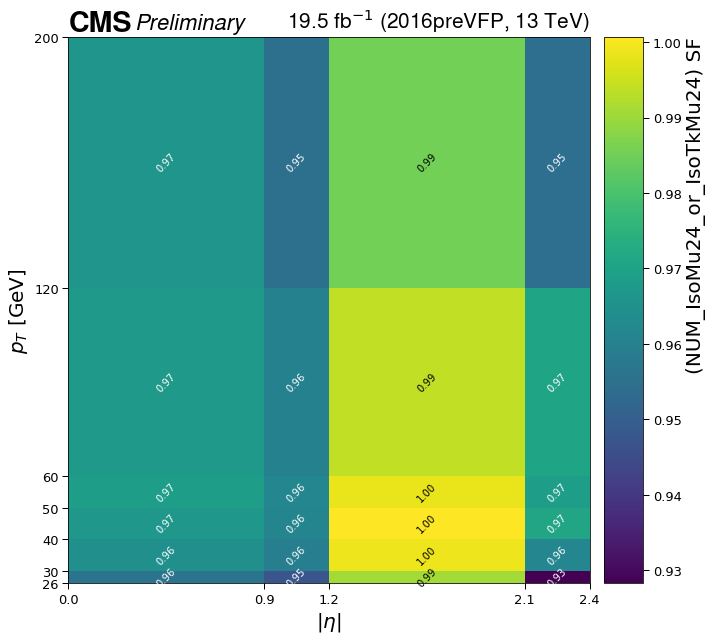

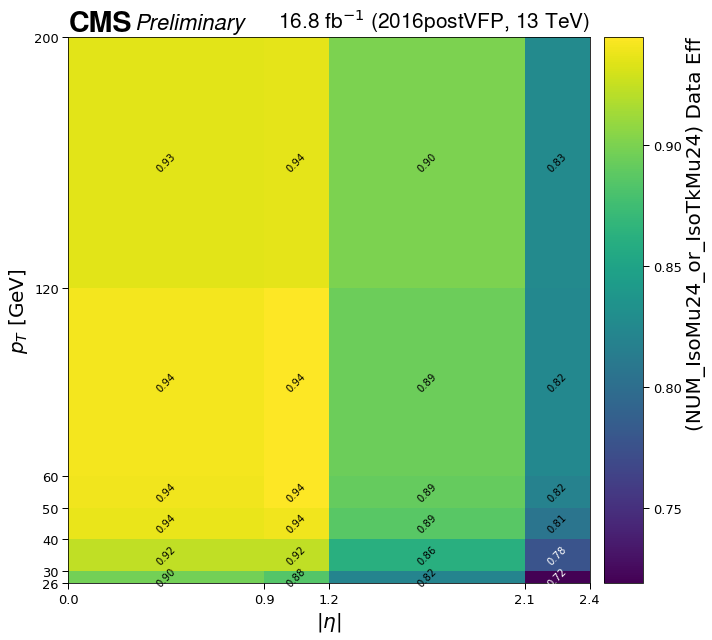

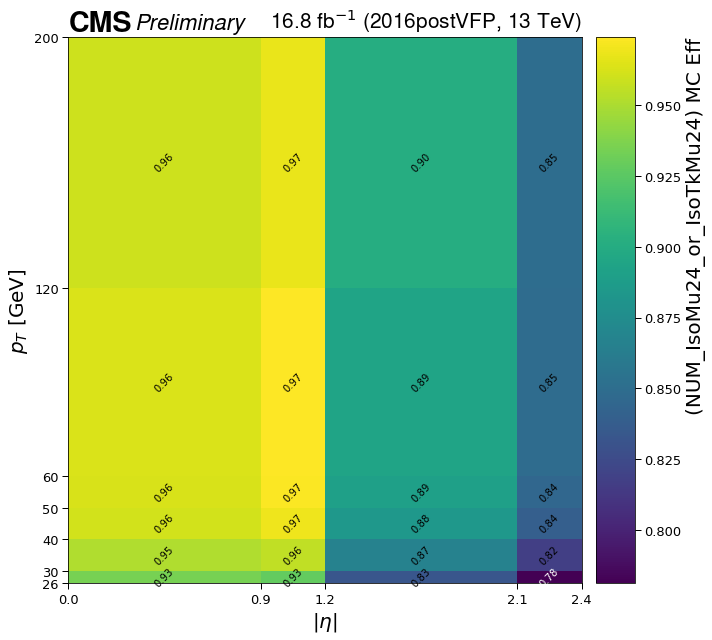

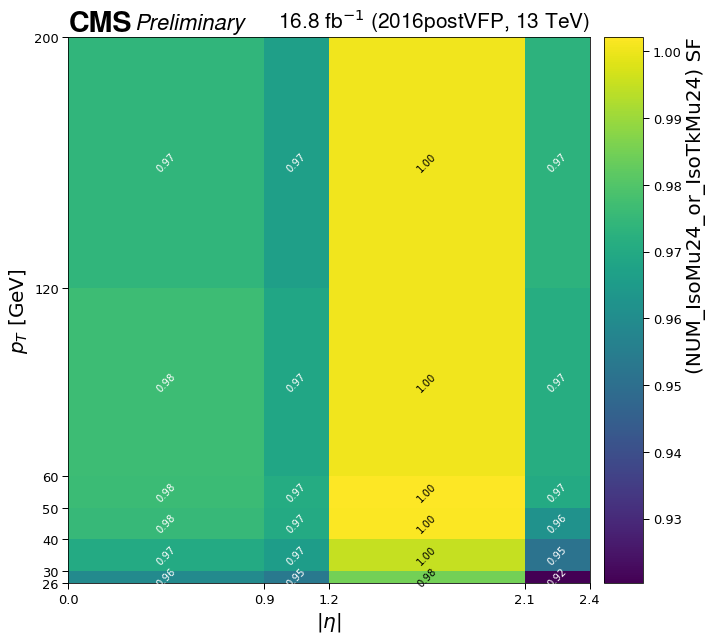

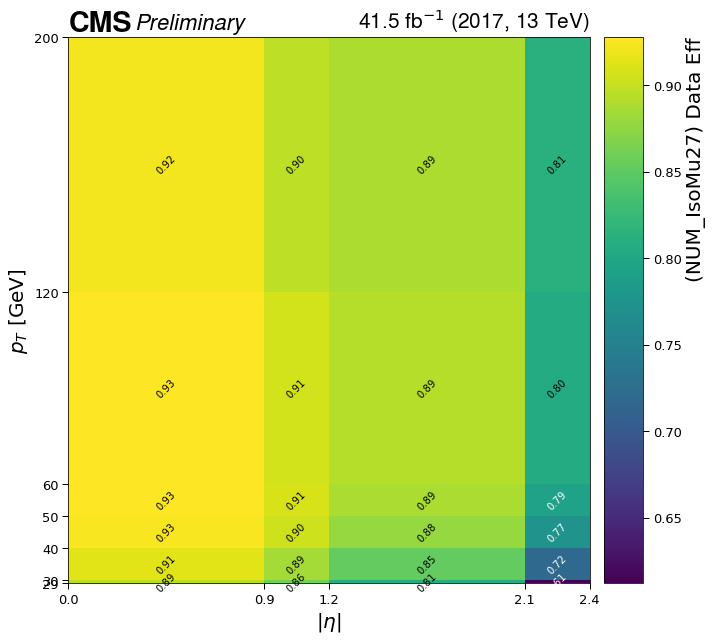

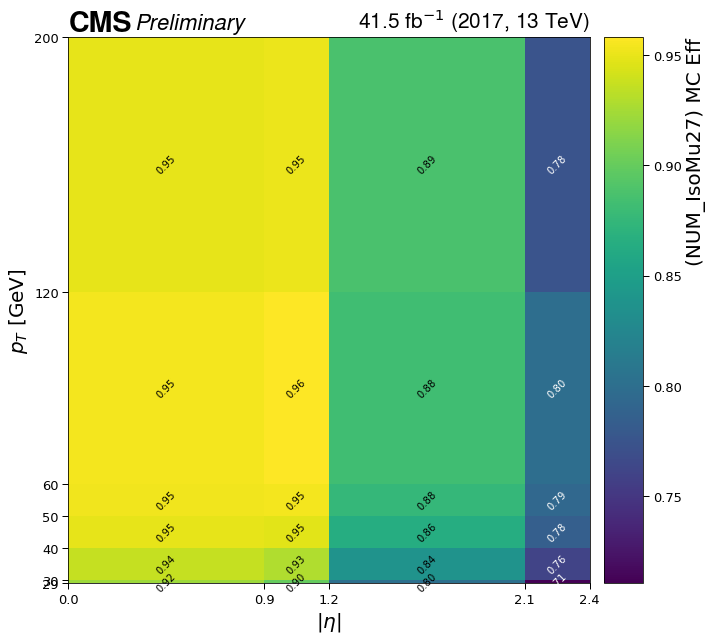

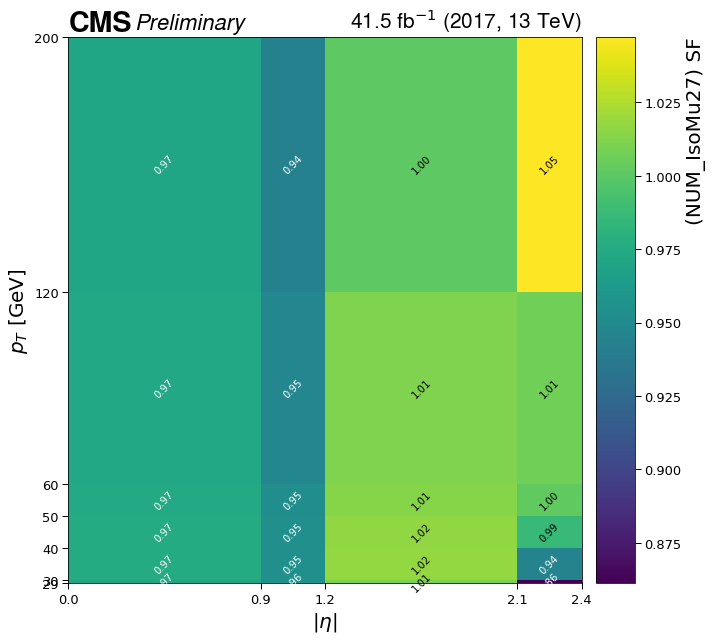

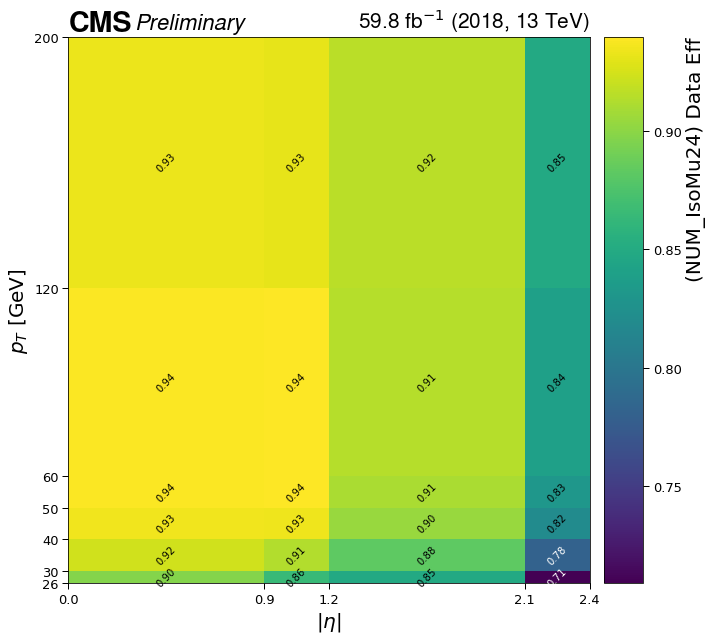

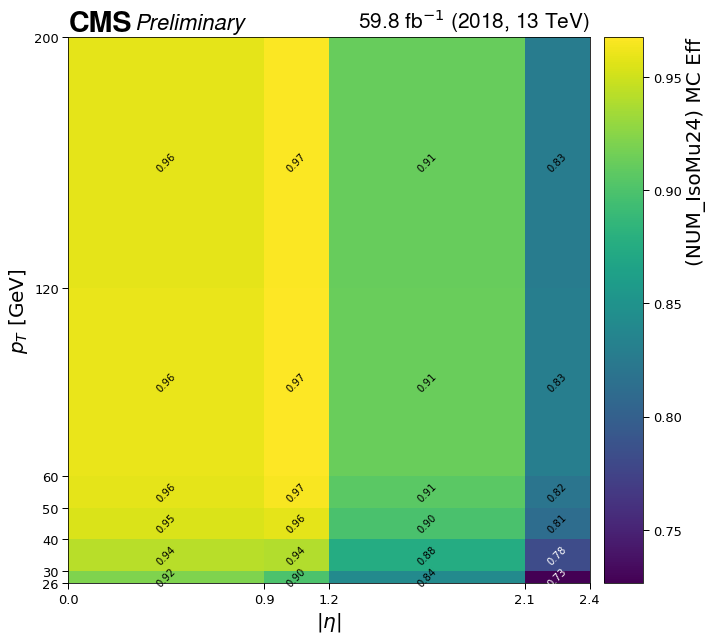

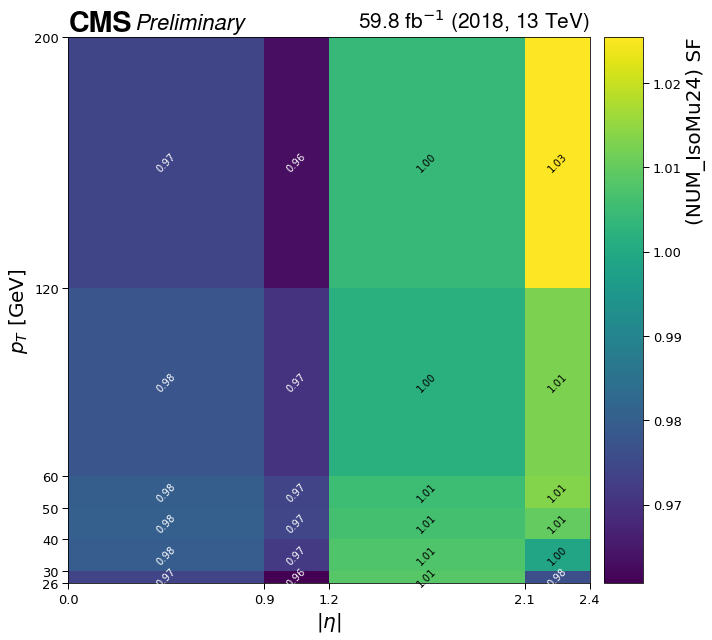

In [2]:
# Files by year
root_files = {
    "2016preVFP": "../analysis/data/Efficiencies_muon_generalTracks_Z_Run2016_UL_HIPM_SingleMuonTriggers.root",
    "2016postVFP": "../analysis/data/Efficiencies_muon_generalTracks_Z_Run2016_UL_SingleMuonTriggers.root",
    "2017": "../analysis/data/Efficiencies_muon_generalTracks_Z_Run2017_UL_SingleMuonTriggers.root",
    "2018": "../analysis/data/Efficiencies_muon_generalTracks_Z_Run2018_UL_SingleMuonTriggers.root",
}
# Base histograms
base_hists = {
    "2016preVFP": "NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt",
    "2016postVFP": "NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt",
    "2017": "NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt",
    "2018": "NUM_IsoMu24_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt"
}
labels = {
    "NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt": "NUM_IsoMu24_or_IsoTkMu24",
    "NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt": "NUM_IsoMu27",
    "NUM_IsoMu24_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt": "NUM_IsoMu24",
}

def add_text(histogram, ax, threshold):
    matrix = histogram.values()
    pt_centers = histogram.axes[0].centers
    eta_centers = histogram.axes[1].centers
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            x = pt_centers[i]
            y = eta_centers[j]
            if val < threshold or np.isnan(val):
                col = "w"
            else:
                col = "k"
            ax.text(
                x,
                y,
                f"{val:.2f}",
                rotation=45,
                ha="center",
                va="center",
                fontsize=10,
                color=col,
            )


def add_info(year, ax):
    with open("../analysis/postprocess/luminosity.yaml", "r") as f:
        lumi = yaml.safe_load(f)
    hep.cms.lumitext(
        f"{lumi[year] * 1e-3:.1f} fb$^{{-1}}$ ({year}, 13 TeV)", ax=ax, fontsize=22
    )
    hep.cms.text("Preliminary", fontsize=22, ax=ax)
    ax.set_xlabel("$|\eta$|", fontsize=20)
    ax.set_ylabel("$p_T$ [GeV]", fontsize=20)


def plot_sf(sf_hist, year, threshold=0.98):
    fig, ax = plt.subplots(figsize=(10, 9), tight_layout=True)
    colormesh = sf_hist.plot2d(ax=ax)
    colormesh[1].set_label(f"({labels[hlt]}) SF", loc="top", fontsize=20)
    add_info(year, ax)
    add_text(sf_hist, ax, threshold)
    fig.savefig(f"{year}_{labels[hlt]}_SF.pdf")


def plot_eff(eff_hist, year, is_mc=True, threshold=0.8):
    kind = "MC" if is_mc else "Data"
    fig, ax = plt.subplots(figsize=(10, 9), tight_layout=True)
    colormesh = eff_hist.plot2d(ax=ax)
    colormesh[1].set_label(f"({labels[hlt]}) {kind} Eff", loc="top", fontsize=20)
    add_info(year, ax)
    add_text(eff_hist, ax, threshold)
    fig.savefig(f"{year}_{labels[hlt]}_{kind.lower()}Eff.pdf")


for year, hlt in base_hists.items():
    tree = uproot.open(root_files[year])
    sfhist = tree[hlt].to_hist()
    data_effhist = tree[f"{hlt}_efficiencyData"].to_hist()
    mc_effhist = tree[f"{hlt}_efficiencyMC"].to_hist()

    plot_eff(data_effhist, year, is_mc=False)
    plot_eff(mc_effhist, year, is_mc=True)
    plot_sf(sfhist, year)

In [3]:
# Inputs for Correction (excluding 'year')
inputs = [
    cs.Variable(name="ValType", type="string", description="nominal/stat/syst"),
    cs.Variable(name="Path", type="string", description="trigger path"),
    cs.Variable(name="eta", type="real", description="muon pseudorapidity"),
    cs.Variable(name="pt", type="real", description="muon pT [GeV]"),
]

output = cs.Variable(
    name="weight", type="real", description="efficiency or uncertainty"
)
valtypes = ["nominal", "stat", "syst"]
paths = {
    "2016preVFP": ["NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight"],
    "2016postVFP": ["NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight"],
    "2017": ["NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight"],
    "2018": ["NUM_IsoMu24_DEN_CutBasedIdTight_and_PFIsoTight"],
}

# Process each year
for year_tag, root_path in root_files.items():
    with uproot.open(root_path) as f:
        all_contents = {}
        edges_set = None

        for ds in ["MC", "Data"]:
            try:
                th2_nom = f[f"{base_hists[year_tag]}_efficiency{ds}"]
                th2_stat = f[f"{base_hists[year_tag]}_efficiency{ds}_stat"]
                th2_syst = f[f"{base_hists[year_tag]}_efficiency{ds}_syst"]
            except KeyError as e:
                print(f"⚠️ Skipping {year_tag} {ds}: missing histogram - {e}")
                continue

            # Read bin edges and ensure proper ordering
            pt_edges = th2_nom.axis(1).edges().tolist()  # X axis: pT
            eta_edges = th2_nom.axis(0).edges().tolist()  # Y axis: eta

            if not edges_set:
                print(f"✔️ Bin edges set for {year_tag}")
                print(f"    eta_edges: {eta_edges}")
                print(f"    pt_edges : {pt_edges}")
                edges_set = {"eta": eta_edges, "pt": pt_edges}

            # Transpose so eta is the outer axis
            nom = th2_nom.values().T.flatten(order="C").tolist()
            stat = th2_stat.values().T.flatten(order="C").tolist()
            syst = th2_syst.values().T.flatten(order="C").tolist()

            all_contents[ds] = {"nominal": nom, "stat": stat, "syst": syst}

        if not all_contents:
            print(f"⚠️ Skipping {year_tag}: no valid histograms found.")
            continue

        corrections = []

        for ds, contents in all_contents.items():
            leaves = {}
            for vt in valtypes:
                content = contents[vt]
                n_eta = len(edges_set["eta"]) - 1
                n_pt = len(edges_set["pt"]) - 1
                expected = n_eta * n_pt

                if len(content) != expected:
                    print(
                        f"⚠️ Skipping {year_tag} {ds} {vt}: {len(content)} values, expected {expected}"
                    )
                    continue

                # ✅ Ensure input dimensions align with bin edges
                mb = cs.MultiBinning(
                    nodetype="multibinning",
                    inputs=["eta", "pt"],
                    edges=[edges_set["eta"], edges_set["pt"]],
                    content=content,
                    flow="error",
                )
                leaves[vt] = mb

            # Nest structure: ValType → Path
            valtype_cat = cs.Category(
                nodetype="category",
                input="ValType",
                content=[
                    cs.CategoryItem(
                        key=vt,
                        value=cs.Category(
                            nodetype="category",
                            input="Path",
                            content=[
                                cs.CategoryItem(
                                    key=paths[year_tag][0], value=leaves[vt]
                                )
                            ],
                        ),
                    )
                    for vt in leaves
                ],
            )

            name = "Muon-HLT-DataEff" if ds == "Data" else "Muon-HLT-McEff"
            desc = f"Muon HLT {ds} efficiencies and uncertainties (nominal/stat/syst) for {year_tag}."

            corrections.append(
                cs.Correction(
                    name=name,
                    description=desc,
                    version=2,
                    inputs=inputs,
                    output=output,
                    data=valtype_cat,
                )
            )

        cset = cs.CorrectionSet(
            schema_version=2,
            description=f"Muon HLT {year_tag} efficiencies and uncertainties",
            corrections=corrections,
        )

        outname = f"../analysis/data/{year_tag}_Muon_HLT_Eff.json"
        with open(outname, "w") as fout:
            fout.write(cset.json(indent=2, exclude_unset=True))
        print(f"✅ Written: {outname}")

✔️ Bin edges set for 2016preVFP
    eta_edges: [0.0, 0.9, 1.2, 2.1, 2.4]
    pt_edges : [26.0, 30.0, 40.0, 50.0, 60.0, 120.0, 200.0]
✅ Written: ../analysis/data/2016preVFP_Muon_HLT_Eff.json
✔️ Bin edges set for 2016postVFP
    eta_edges: [0.0, 0.9, 1.2, 2.1, 2.4]
    pt_edges : [26.0, 30.0, 40.0, 50.0, 60.0, 120.0, 200.0]
✅ Written: ../analysis/data/2016postVFP_Muon_HLT_Eff.json
✔️ Bin edges set for 2017
    eta_edges: [0.0, 0.9, 1.2, 2.1, 2.4]
    pt_edges : [29.0, 30.0, 40.0, 50.0, 60.0, 120.0, 200.0]
✅ Written: ../analysis/data/2017_Muon_HLT_Eff.json
✔️ Bin edges set for 2018
    eta_edges: [0.0, 0.9, 1.2, 2.1, 2.4]
    pt_edges : [26.0, 30.0, 40.0, 50.0, 60.0, 120.0, 200.0]
✅ Written: ../analysis/data/2018_Muon_HLT_Eff.json
